In [128]:
# Data Handling
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import os
from numpy.random import seed

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Technical Analysis
import ta 

# Visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff

In [129]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [130]:
seed(42)

In [141]:
# Read data into Dataframe
data=pd.read_csv('model_data.csv')

In [142]:
def null_value_checks(data_frame):
    print('=====================================')
    print('====  Running Null Value Check  ==== ')
    temp=data_frame.isnull().sum(axis=0).sort_values(ascending=False).rename('Null_Values').reset_index()
    if len(temp[temp['Null_Values']>0])==0:
      print(' == There are no NaNs in the Data Frame ==')
    else:
      print(' == There are NaNs in the Data Frame. Columns are listed below ==')
      print(temp[temp['Null_Values']>0])
    print('=====================================')
    
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Mean absolute Percentage Error is : ',mape)
    return mape

In [143]:
data.head(2)

,Date,Lloyds_Close
0,03/03/2009,45.5
1,04/03/2009,47.7


In [144]:
data.tail(2)

,Date,Lloyds_Close
2876,28/08/2020,28.35
2877,01/09/2020,


In [135]:
model_data=data[['Date','Lloyds_Close']]

In [136]:
data=model_data

In [145]:
data.head()

,Date,Lloyds_Close
0,03/03/2009,45.5
1,04/03/2009,47.7
2,05/03/2009,39.32
3,06/03/2009,42.0
4,09/03/2009,43.7


## Dickey Fuller Test 

In [146]:
def adf_test(series,title='',verbose=False):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    if verbose:
        print(f'Augmented Dickey-Fuller Test: {title}')
        print('===============================================')
    
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','Lags','Data']
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    if verbose:
        print(out.to_string())          
        print('===============================================')
        if result[1] <= 0.05:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")                
            print("Data has no unit root and is stationary")
        else:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
    return out

def adf_report(dataframe):
    adf_results=pd.DataFrame()
    adf_report=pd.DataFrame()
    
    for col in list(dataframe):
        result=adf_test(data_adf_test[col],title=col,verbose=False)
        adf_results[col]=result.apply(lambda x : round(x,2))
        adf_report=adf_results.loc['p-value'].reset_index()
        
    print("==========================================================================")
    print("The following attributes have Strong evidence against the null hypothesis")
    print("Reject the null hypothesis")
    print("Data has no unit root and is Stationary"+'\n')
    print(adf_report[adf_report['p-value'] <= 0.05][['index','p-value']])  
    print('\n'+"==========================================================================")
    print("The following attributes have Weak evidence against the null hypothesis")
    print("Fail to Reject the null hypothesis")
    print("Data has a unit root and is non-stationary"+'\n')
    print(adf_report[adf_report['p-value'] > 0.05][['index','p-value']])  
    
    return adf_results

In [53]:
data_adf_test=data[['Lloyds_Open','Lloyds_High','Lloyds_Low','Lloyds_Close','Volume','SMA_10','WMA_10','rsi','stoc_k','stoc_d','mom','macd','adosc','cci','willr','GBP/USD Price','Oil_Price','FTSE_Price']]

In [150]:
data=data[:-1][:]

In [151]:
data['Lloyds_Close']=data['Lloyds_Close'].astype(float)

In [152]:
_=adf_test(data['Lloyds_Close'],'Close Price of Lloyds Share',verbose=True)

Augmented Dickey-Fuller Test: Close Price of Lloyds Share
ADF test statistic        -2.588706
p-value                    0.095354
Lags                      28.000000
Data                    2848.000000
critical value (1%)       -3.432648
critical value (5%)       -2.862555
critical value (10%)      -2.567311
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Granger Causality Test 

In [11]:
null_value_checks(data_adf_test)

====  Running Null Value Check  ==== 
 == There are no NaNs in the Data Frame ==


In [12]:
data_adf_test.head(2)

,Lloyds_Open,Lloyds_High,Lloyds_Low,Lloyds_Close,Volume,SMA_10,WMA_10,rsi,stoc_k,stoc_d,mom,macd,adosc,cci,willr,GBP/USD Price,Oil_Price,FTSE_Price
0,50.8,53.9,44.1,45.5,104107533.0,55.83,55.680000,37.073918,14.764681,12.192351,-45.4,-13.657867,-4.699649e+07,-145.438898,-95.965418,1.4059,41.65,3512.1
1,45.3,49.4,45.3,47.7,60277100.0,54.96,54.201818,38.680117,14.718483,13.015858,-8.7,-13.881083,-5.072661e+07,-116.507236,-89.625360,1.4164,45.38,3645.9


In [27]:
def granger_causuality_test(dataframe):
    cols=list(dataframe)
    grange_matrix=pd.DataFrame(np.zeros((len(cols),len(cols))),columns=cols,index=cols)
    for i in grange_matrix.columns:
          for j in grange_matrix.index:
            result=grangercausalitytests(dataframe[[j,i]],maxlag=15,verbose=False)
            p_values= [result[k+1][0]['ssr_chi2test'][1] for k in range(15)]
            min_p_value=np.min(p_values)
            grange_matrix.loc[j,i]=round(min_p_value,4)
    #grange_matrix.columns=[col+'_x' for col in cols]
    #grange_matrix.index=[col+'_y' for col in cols]
    
    temp=grange_matrix.loc['Lloyds_Close'][:].reset_index()
    
    print("==========================================================================")
    print("The following attributes have Strong evidence against the null hypothesis")
    print("Reject the null hypothesis")
    print("These variables have causation effect on Lloyds Close"+'\n')
    print(temp[temp['Lloyds_Close'] <= 0.05][['index','Lloyds_Close']])  
    print('\n'+"==========================================================================")
    print("The following attributes have Weak evidence against the null hypothesis")
    print("Fail to Reject the null hypothesis")
    print("These variables do not have causation effect on Lloyds Close"+'\n')
    print(temp[temp['Lloyds_Close'] > 0.05][['index','Lloyds_Close']])  
    
    return grange_matrix

In [28]:
grange_matrix=granger_causuality_test(data_adf_test)

The following attributes have Strong evidence against the null hypothesis
Reject the null hypothesis
These variables have causation effect on Lloyds Close

            index  Lloyds_Close
0     Lloyds_Open        0.0000
1     Lloyds_High        0.0000
2      Lloyds_Low        0.0000
4          Volume        0.0193
5          SMA_10        0.0000
6          WMA_10        0.0000
7             rsi        0.0003
8          stoc_k        0.0001
9          stoc_d        0.0013
10            mom        0.0000
11           macd        0.0000
13            cci        0.0158
14          willr        0.0048
15  GBP/USD Price        0.0062
16      Oil_Price        0.0292

The following attributes have Weak evidence against the null hypothesis
Fail to Reject the null hypothesis
These variables do not have causation effect on Lloyds Close

           index  Lloyds_Close
3   Lloyds_Close        1.0000
12         adosc        0.1973
17    FTSE_Price        0.0738


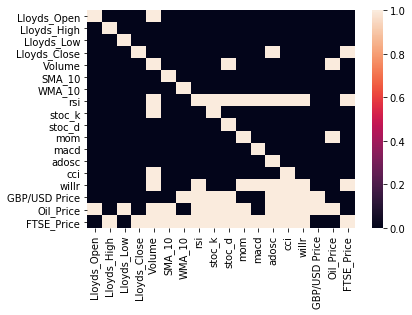

In [29]:
grange_matrix_sparse=pd.DataFrame()
for col in list(grange_matrix):
    grange_matrix_sparse[col]=grange_matrix[col].apply(lambda x : 1 if x >= 0.05 else 0)

sns.heatmap(grange_matrix_sparse)
plt.show()

In [15]:
#data.set_index('Date',inplace=True)

## TEST/TRAIN SPLIT

In [118]:
%%writefile -a modelling.py
data_train, data_test = train_test_split(data, train_size=0.90, test_size=0.10, shuffle=False)

Appending to modelling.py


In [93]:
data_adf_test.shape

(2876, 18)

In [94]:
data_train.head(2)

,Date,Lloyds_Close
0,2009-03-03,45.5
1,2009-03-04,47.7


In [95]:
data_train.tail(2)

,Date,Lloyds_Close
2586,2019-07-03,58.26
2587,2019-07-04,58.26


In [96]:
data_test.head(2)

,Date,Lloyds_Close
2588,2019-07-05,57.83
2589,2019-07-08,57.71


In [97]:
data_test.tail(2)

,Date,Lloyds_Close
2874,2020-08-26,28.475
2875,2020-08-27,28.200


In [119]:
%%writefile -a modelling.py
print('Shape of Training data: ',data_train.shape)
print(data_test.shape)

Appending to modelling.py


In [120]:
%%writefile -a modelling.py
print('Shape of Validation data: ',data_val.shape)
print('Shape of Test data: ',data_test.shape)

Appending to modelling.py


# Holt Winters Model

In [38]:
data_train['DESadd12'] = ExponentialSmoothing(data_train['Lloyds_Close'],trend='add').fit().fittedvalues.shift(-1)
data_train['TESadd12'] = ExponentialSmoothing(data_train['Lloyds_Close'],trend='add',seasonal='add',seasonal_periods=2).fit().fittedvalues


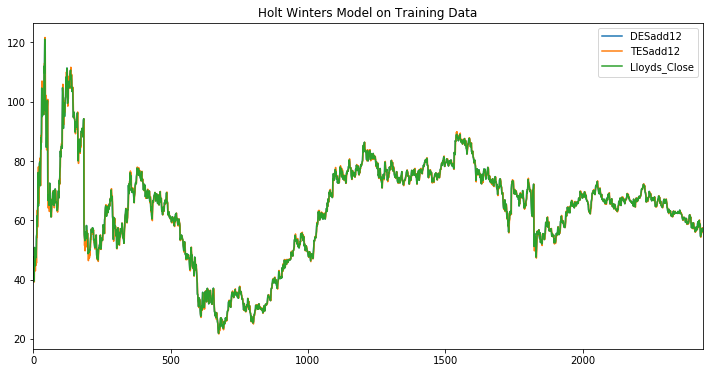

In [39]:
data_train[['DESadd12','TESadd12','Lloyds_Close']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.title('Holt Winters Model on Training Data')
plt.show()

In [40]:
start_time=dt.datetime.now()
model=ExponentialSmoothing(data_train['Lloyds_Close'],trend='add').fit()
print('Training Time is : ',dt.datetime.now()-start_time)

Training Time is :  0:00:00.042301


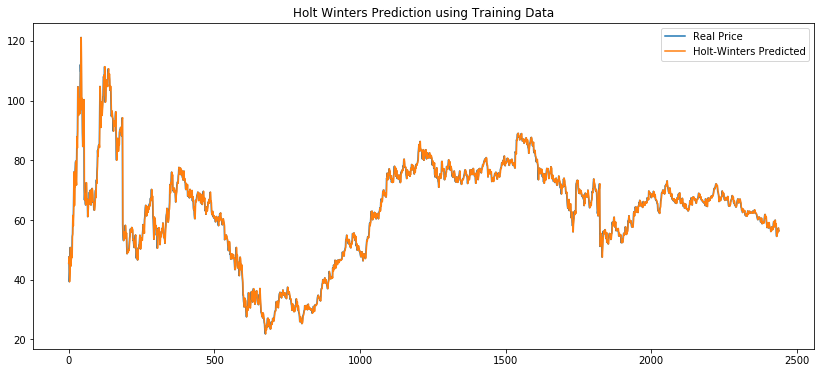

In [41]:
start_time=dt.datetime.now()
pred_train = model.predict(start=data_train['Lloyds_Close'].index[0], end=data_train['Lloyds_Close'].index[-1])


plt.figure(figsize=(14,6))
plt.plot(data_train['Lloyds_Close'], label='Real Price')
plt.plot(pred_train, label='Holt-Winters Predicted')
plt.title('Holt Winters Prediction using Training Data')
plt.xticks()
plt.legend(loc='best')
plt.show()

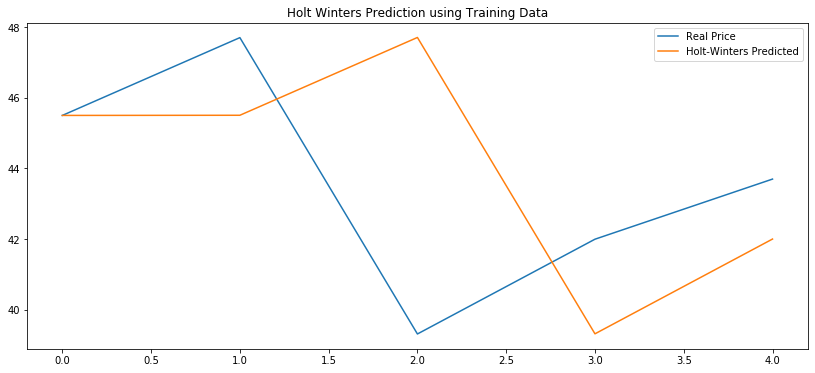

In [42]:
plt.figure(figsize=(14,6))
plt.plot(data_train['Lloyds_Close'][:5], label='Real Price')
plt.plot(pred_train[:5], label='Holt-Winters Predicted')
plt.title('Holt Winters Prediction using Training Data')
plt.legend(loc='best')
plt.show()

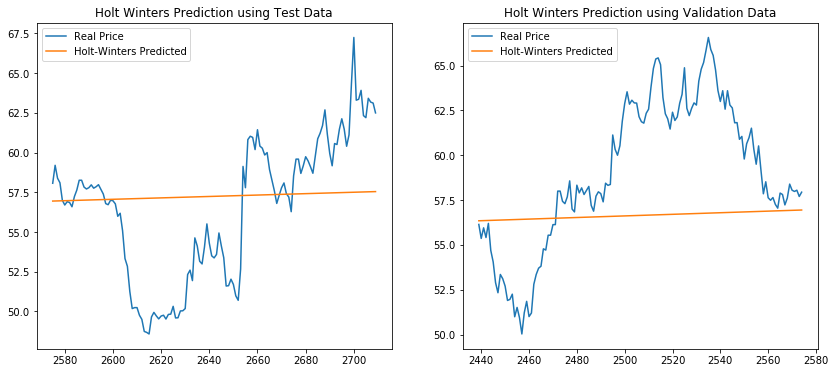

In [46]:
plt.figure(figsize=(14,6))
plt.subplot(121)
pred_test = model.predict(start=data_test['Lloyds_Close'].index[0], end=data_test['Lloyds_Close'].index[-1])
plt.plot(data_test['Lloyds_Close'], label='Real Price')
plt.plot(pred_test, label='Holt-Winters Predicted')
plt.title('Holt Winters Prediction using Test Data')
plt.legend(loc='best')

plt.subplot(122)
pred_val = model.predict(start=data_val['Lloyds_Close'].index[0], end=data_val['Lloyds_Close'].index[-1])
plt.plot(data_val['Lloyds_Close'], label='Real Price')
plt.plot(pred_val, label='Holt-Winters Predicted')
plt.title('Holt Winters Prediction using Validation Data')
plt.legend(loc='best')

plt.show()

In [61]:
pred_train[:2]

0    45.499937
1    45.504445
dtype: float64

In [62]:
mape_training=mean_absolute_percentage_error(data_train['Lloyds_Close'],pred_train)
mape_test_2=mean_absolute_percentage_error(data_test['Lloyds_Close'][:2],pred_test[:2])
mape_val_2=mean_absolute_percentage_error(data_val['Lloyds_Close'][:2],pred_val[:2])
mape_test_5=mean_absolute_percentage_error(data_test['Lloyds_Close'][:5],pred_test[:5])
mape_val_5=mean_absolute_percentage_error(data_val['Lloyds_Close'][:5],pred_val[:5])


mae_training=mean_absolute_error(data_train['Lloyds_Close'],pred_train)
mae_test_2=mean_absolute_error(data_test['Lloyds_Close'][:2],pred_test[:2])
mae_val_2=mean_absolute_error(data_val['Lloyds_Close'][:2],pred_val[:2])
mae_test_5=mean_absolute_error(data_test['Lloyds_Close'][:5],pred_test[:5])
mae_val_5=mean_absolute_error(data_val['Lloyds_Close'][:5],pred_val[:5])

print('MAPE of Training Data : ',round(mape_training,3))
print('-'*30)
print('MAPE of Test Data (Short-term prediction) : ', round(mape_test_2,3))
print('MAPE of Validation Data (Short-term prediction) : ', round(mape_val_2,3))
print('-'*30)
print('MAPE of Test Data (Long-term prediction) : ', round(mape_test_5,3))
print('MAPE of Validation Data (Long-term prediction) : ', round(mape_val_5,3))
print('-'*30)
print('MAE of Training Data : ',round(mae_training,3))
print('-'*30)
print('MAE of Test Data (Short-term prediction) : ', round(mae_test_2,3))
print('MAE of Validation Data (Short-term prediction) : ', round(mae_val_2,3))
print('-'*30)
print('MAE of Test Data (Long-term prediction) : ', round(mae_test_5,3))
print('MAE of Validation Data (Long-term prediction) : ', round(mae_val_5,3))

MAPE of Training Data :  1.708
------------------------------
MAPE of Test Data (Short-term prediction) :  2.863
MAPE of Validation Data (Short-term prediction) :  1.075
------------------------------
MAPE of Test Data (Long-term prediction) :  2.039
MAPE of Validation Data (Long-term prediction) :  0.974
------------------------------
MAE of Training Data :  1.029
------------------------------
MAE of Test Data (Short-term prediction) :  1.684
MAE of Validation Data (Short-term prediction) :  0.597
------------------------------
MAE of Test Data (Long-term prediction) :  1.194
MAE of Validation Data (Long-term prediction) :  0.541


# Manual ARIMA

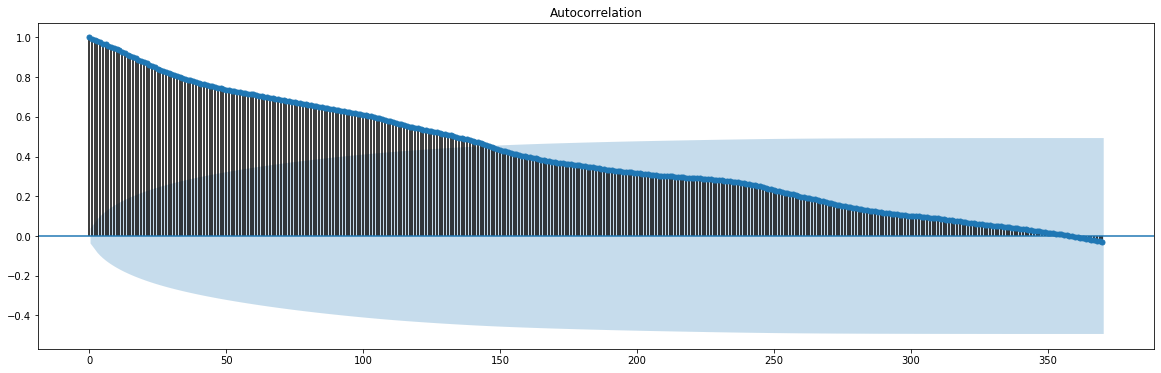

In [63]:
# Plot ACF plot
plt.rcParams["figure.figsize"] = [20, 6]
plot_acf(data['Lloyds_Close'],lags=370)
plt.show()

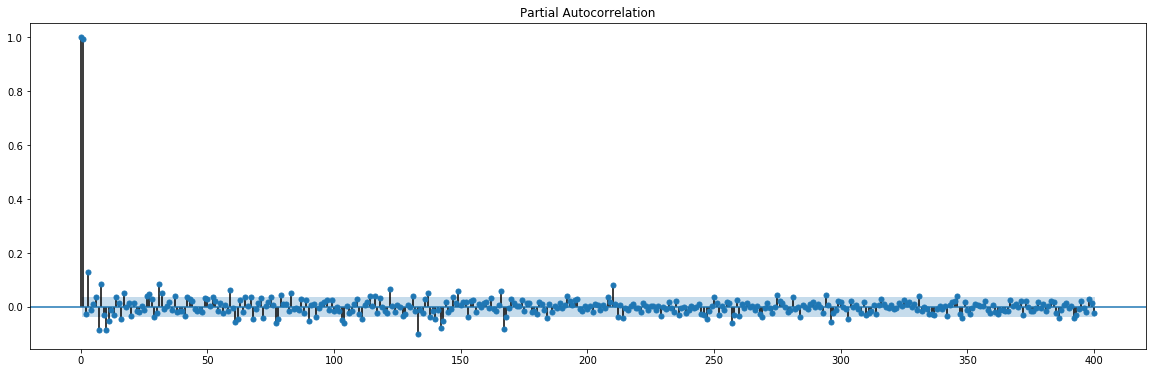

In [64]:
# Plot Partial ACF plot
plt.rcParams["figure.figsize"] = [20, 6]
plot_pacf(data['Lloyds_Close'],lags=400)
plt.show()

In [65]:
diff=pd.DataFrame(columns=['Lloyds_Close'])
diff=data['Lloyds_Close'].diff()
diff=diff.reset_index()

In [66]:
diff=diff[~diff['Lloyds_Close'].isna()]

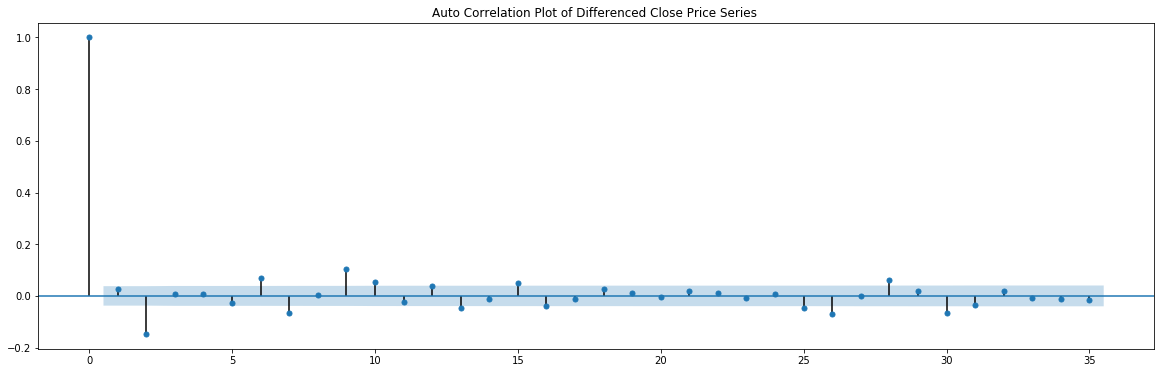

In [67]:
# Plot ACF plot
plt.rcParams["figure.figsize"] = [20, 6]
plot_acf(diff['Lloyds_Close'])
plt.title('Auto Correlation Plot of Differenced Close Price Series ')
plt.show()

### ARIMA Manual Order Derived - (1,1,0)

In [13]:
def manual_arima_model(train_data, test_data, order):
    print('Shape of train data : ',train_data.shape)
    print('Shape of test data : ',test_data.shape)
    print('Order of ARIMA : ',order)
    train_array =train_data['Lloyds_Close'].values
    test_array = test_data['Lloyds_Close'].values
    history = [x for x in train_array]
    predictions = []
    return_values = []
    for i in range(len(test_array)):
        model = ARIMA(history, order=order)
        result = model.fit()
        output = result.forecast()
        predictions.append(output[0])
        history.append(test_array[i])
    
    print('** Model fit Complete **')
    for j in range(len(predictions)):
        return_values.append(list(predictions[j])[0])
        
    return return_values

In [69]:
start_time=dt.datetime.now()
predictions_train=manual_arima_model(data_train,data_train,(1,1,0))
data_train['Predictions_Manual_ARIMA']=predictions_train
print('Training Time  : ',dt.datetime.now()-start_time)

predictions_test=manual_arima_model(data_train,data_test,(1,1,0))
data_test['Predictions_Manual_ARIMA']=predictions_test


predictions_val=manual_arima_model(data_train,data_val,(1,1,0))
data_val['Predictions_Manual_ARIMA']=predictions_val

Shape of train data :  (2439, 24)
Shape of test data :  (2439, 24)
Order of ARIMA :  (1, 1, 0)
** Model fit Complete **
Training Time  :  0:00:58.738902
Shape of train data :  (2439, 25)
Shape of test data :  (135, 22)
Order of ARIMA :  (1, 1, 0)
** Model fit Complete **
Shape of train data :  (2439, 25)
Shape of test data :  (136, 22)
Order of ARIMA :  (1, 1, 0)
** Model fit Complete **


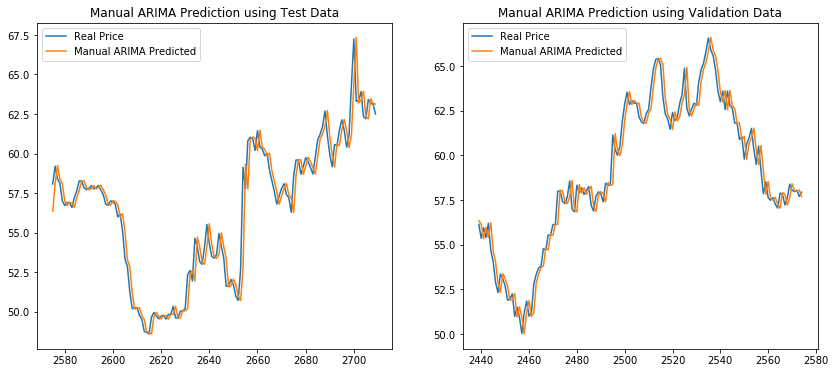

In [73]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data_test['Lloyds_Close'], label='Real Price')
plt.plot(data_test['Predictions_Manual_ARIMA'], label='Manual ARIMA Predicted')
plt.title('Manual ARIMA Prediction using Test Data')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(data_val['Lloyds_Close'], label='Real Price')
plt.plot(data_val['Predictions_Manual_ARIMA'], label='Manual ARIMA Predicted')
plt.title('Manual ARIMA Prediction using Validation Data')
plt.legend(loc='best')

plt.show()

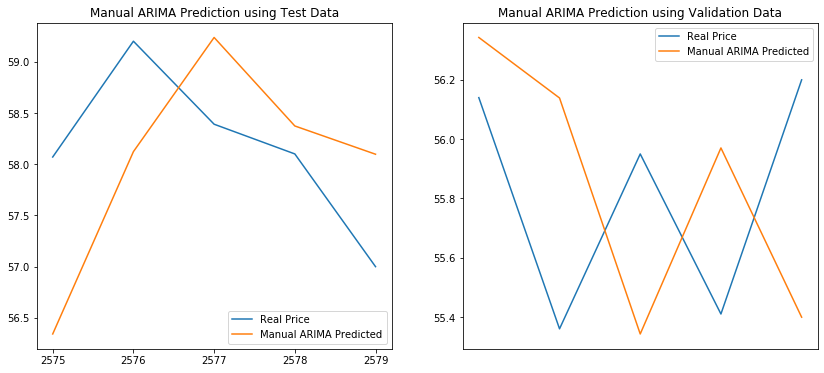

In [74]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data_test['Lloyds_Close'][:5], label='Real Price')
plt.xticks(data_test['Lloyds_Close'].index[:5])
plt.plot(data_test['Predictions_Manual_ARIMA'][:5], label='Manual ARIMA Predicted')
plt.title('Manual ARIMA Prediction using Test Data')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(data_val['Lloyds_Close'][:5], label='Real Price')
plt.xticks(data_test['Lloyds_Close'].index[:5])
plt.plot(data_val['Predictions_Manual_ARIMA'][:5], label='Manual ARIMA Predicted')
plt.title('Manual ARIMA Prediction using Validation Data')

plt.legend(loc='best')

plt.show()


In [75]:
mape_train=mean_absolute_percentage_error(data_train['Lloyds_Close'],data_train['Predictions_Manual_ARIMA'])
mae_train=mean_absolute_error(data_train['Lloyds_Close'],data_train['Predictions_Manual_ARIMA'])

mape_test_2=mean_absolute_percentage_error(data_test['Lloyds_Close'][:2],data_test['Predictions_Manual_ARIMA'][:2])
mape_val_2=mean_absolute_percentage_error(data_val['Lloyds_Close'][:2],data_val['Predictions_Manual_ARIMA'][:2])
mape_test_5=mean_absolute_percentage_error(data_test['Lloyds_Close'][:5],data_test['Predictions_Manual_ARIMA'][:5])
mape_val_5=mean_absolute_percentage_error(data_val['Lloyds_Close'][:5],data_val['Predictions_Manual_ARIMA'][:5])

mae_test_2=mean_absolute_error(data_test['Lloyds_Close'][:2],data_test['Predictions_Manual_ARIMA'][:2])
mae_val_2=mean_absolute_error(data_val['Lloyds_Close'][:2],data_val['Predictions_Manual_ARIMA'][:2])
mae_test_5=mean_absolute_error(data_test['Lloyds_Close'][:5],data_test['Predictions_Manual_ARIMA'][:5])
mae_val_5=mean_absolute_error(data_val['Lloyds_Close'][:5],data_val['Predictions_Manual_ARIMA'][:5])

print('MAPE of Training Data : ',round(mape_train,3))
print('MAE of Training Data : ',round(mae_train,3))
print('-'*30)
print('MAPE of Test Data (Short-term prediction) : ', round(mape_test_2,3))
print('MAPE of Validation Data (Short-term prediction) : ', round(mape_val_2,3))
print('-'*30)
print('MAPE of Test Data (Long-term prediction) : ', round(mape_test_5,3))
print('MAPE of Validation Data (Long-term prediction) : ', round(mape_val_5,3))
print('-'*30)
print('MAE of Training Data : ',round(mae_training,3))
print('-'*30)
print('MAE of Test Data (Short-term prediction) : ', round(mae_test_2,3))
print('MAE of Validation Data (Short-term prediction) : ', round(mae_val_2,3))
print('-'*30)
print('MAE of Test Data (Long-term prediction) : ', round(mae_test_5,3))
print('MAE of Validation Data (Long-term prediction) : ', round(mae_val_5,3))


MAPE of Training Data :  1.718
MAE of Training Data :  1.034
------------------------------
MAPE of Test Data (Short-term prediction) :  2.397
MAPE of Validation Data (Short-term prediction) :  0.884
------------------------------
MAPE of Test Data (Long-term prediction) :  1.728
MAPE of Validation Data (Long-term prediction) :  1.058
------------------------------
MAE of Training Data :  1.029
------------------------------
MAE of Test Data (Short-term prediction) :  1.402
MAE of Validation Data (Short-term prediction) :  0.491
------------------------------
MAE of Test Data (Long-term prediction) :  1.004
MAE of Validation Data (Long-term prediction) :  0.59


## Auto ARIMA

## Identify the ARIMA Order using Grid Search

In [121]:
%%writefile -a modelling.py
arima_fits=auto_arima(data_train['Lloyds_Close'],start_p=0,max_p=7,start_q=0,max_q=7,seasonal=True,trace=True)

Appending to modelling.py


In [122]:
%%writefile -a modelling.py
arima_fits.summary()

Appending to modelling.py


In [123]:
%%writefile -a modelling.py
def arima_model(train_data, test_data, order):
    print('Shape of train data : ',train_data.shape)
    print('Shape of test data : ',test_data.shape)
    print('Order of ARIMA : ',order)
    train_array =train_data['Lloyds_Close'].values
    test_array = test_data['Lloyds_Close'].values
    history = [x for x in train_array]
    predictions = []
    return_values = []
    for i in range(len(test_array)):
        model = ARIMA(history, order=order)
        result = model.fit()
        output = result.forecast()
        predictions.append(output[0])
        history.append(test_array[i])
    
    print('** Model fit Complete **')
    for j in range(len(predictions)):
        return_values.append(list(predictions[j])[0])
        
    return return_values


Appending to modelling.py


# Create Test Forecasts 


In [124]:
%%writefile -a modelling.py
predictions_test=arima_model(data_train,data_test,(2,1,0))
np.save('development_predictions.npy',predictions_test)

Appending to modelling.py


In [125]:
%%writefile -a modelling.py
data_test['Predictions_ARIMA']=predictions_test

Appending to modelling.py


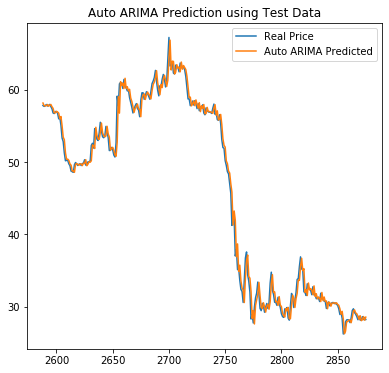

In [105]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data_test['Lloyds_Close'], label='Real Price')
plt.plot(data_test['Predictions_ARIMA'], label='Auto ARIMA Predicted')
plt.title('Auto ARIMA Prediction using Test Data')
plt.legend(loc='best')
plt.show()

# Get Forecast numpy dumps

In [126]:
%%writefile -a modelling.py
train_array =data_all_but_5['Lloyds_Close'].values
history = [x for x in train_array]
preds=[]
for i in range(0,5):
    model = ARIMA(history, order=(2,1,0))
    result = model.fit()
    output = result.forecast()
    #print(output[0])
    preds.append(output[0][0])
    history.append(output[0][0])

print(preds)
np.array(preds)

Appending to modelling.py


In [127]:
%%writefile -a modelling.py
np.save('predictions_dump.npy',preds)

Appending to modelling.py


In [39]:
data.tail(5)['Lloyds_Close']

2871    28.100
2872    28.600
2873    28.200
2874    28.475
2875    28.200
Name: Lloyds_Close, dtype: float64

In [25]:
start_time=dt.datetime.now()
predictions_train=arima_model(data_train,data_train,(2,1,0))
data_train['Predictions_ARIMA']=predictions_train
print('** Training Time  : ',dt.datetime.now()-start_time)

predictions_test=arima_model(data_train,data_test,(2,1,0))
data_test['Predictions_ARIMA']=predictions_test


predictions_val=arima_model(data_train,data_val,(2,1,0))
data_val['Predictions_ARIMA']=predictions_val


Shape of train data :  (2588, 32)
Shape of test data :  (2588, 32)
Order of ARIMA :  (2, 1, 0)
** Model fit Complete **
** Training Time  :  0:01:54.287688
Shape of train data :  (2588, 33)
Shape of test data :  (152, 32)
Order of ARIMA :  (2, 1, 0)
** Model fit Complete **
Shape of train data :  (2588, 33)
Shape of test data :  (136, 32)
Order of ARIMA :  (2, 1, 0)
** Model fit Complete **


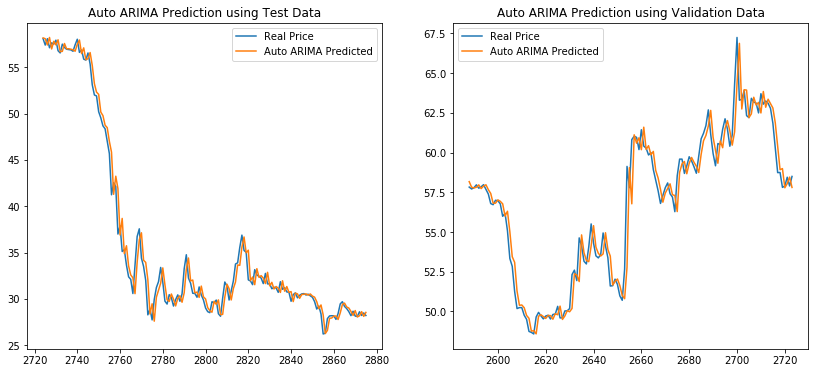

In [26]:

"""
plt.subplot(122)
plt.plot(data_val['Lloyds_Close'], label='Real Price')
plt.plot(data_val['Predictions_ARIMA'], label='Auto ARIMA Predicted')
plt.title('Auto ARIMA Prediction using Validation Data')
plt.legend(loc='best')
"""
plt.show()

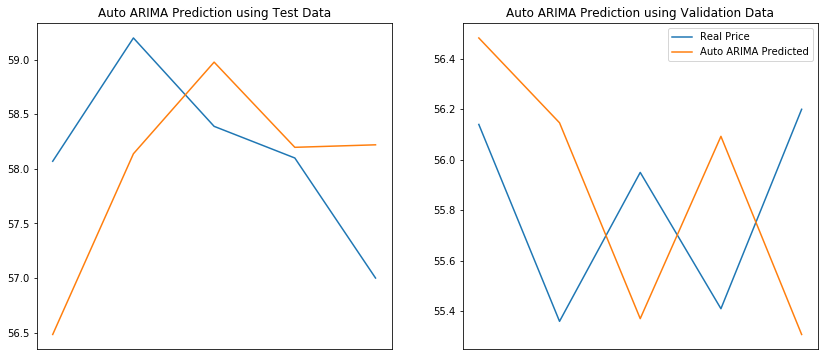

In [81]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data_test['Lloyds_Close'][:5], label='Real Price')
plt.xticks([1,2,3,4,5])
plt.plot(data_test['Predictions_ARIMA'][:5], label='Auto ARIMA Predicted')
plt.title('Auto ARIMA Prediction using Test Data')

plt.subplot(122)
plt.plot(data_val['Lloyds_Close'][:5], label='Real Price')
plt.xticks([1,2,3,4,5])
plt.plot(data_val['Predictions_ARIMA'][:5], label='Auto ARIMA Predicted')
plt.title('Auto ARIMA Prediction using Validation Data')

plt.legend(loc='best')

plt.show()


In [82]:
mape_train=mean_absolute_percentage_error(data_train['Lloyds_Close'],data_train['Predictions_ARIMA'])
mae_train=mean_absolute_error(data_train['Lloyds_Close'],data_train['Predictions_ARIMA'])

mape_test_2=mean_absolute_percentage_error(data_test['Lloyds_Close'][:2],data_test['Predictions_ARIMA'][:2])
mape_val_2=mean_absolute_percentage_error(data_val['Lloyds_Close'][:2],data_val['Predictions_ARIMA'][:2])
mape_test_5=mean_absolute_percentage_error(data_test['Lloyds_Close'][:5],data_test['Predictions_ARIMA'][:5])
mape_val_5=mean_absolute_percentage_error(data_val['Lloyds_Close'][:5],data_val['Predictions_ARIMA'][:5])

mae_test_2=mean_absolute_error(data_test['Lloyds_Close'][:2],data_test['Predictions_ARIMA'][:2])
mae_val_2=mean_absolute_error(data_val['Lloyds_Close'][:2],data_val['Predictions_ARIMA'][:2])
mae_test_5=mean_absolute_error(data_test['Lloyds_Close'][:5],data_test['Predictions_ARIMA'][:5])
mae_val_5=mean_absolute_error(data_val['Lloyds_Close'][:5],data_val['Predictions_ARIMA'][:5])

print('MAPE of Training Data : ',round(mape_train,3))
print('MAE of Training Data : ',round(mae_train,3))
print('-'*30)
print('MAPE of Test Data (Short-term prediction) : ', round(mape_test_2,3))
print('MAPE of Validation Data (Short-term prediction) : ', round(mape_val_2,3))
print('-'*30)
print('MAPE of Test Data (Long-term prediction) : ', round(mape_test_5,3))
print('MAPE of Validation Data (Long-term prediction) : ', round(mape_val_5,3))
print('-'*30)
print('MAE of Test Data (Short-term prediction) : ', round(mae_test_2,3))
print('MAE of Validation Data (Short-term prediction) : ', round(mae_val_2,3))
print('-'*30)
print('MAE of Test Data (Long-term prediction) : ', round(mae_test_5,3))
print('MAE of Validation Data (Long-term prediction) : ', round(mae_val_5,3))


MAPE of Training Data :  1.718
MAE of Training Data :  1.032
------------------------------
MAPE of Test Data (Short-term prediction) :  2.263
MAPE of Validation Data (Short-term prediction) :  1.016
------------------------------
MAPE of Test Data (Long-term prediction) :  1.569
MAPE of Validation Data (Long-term prediction) :  1.177
------------------------------
MAE of Test Data (Short-term prediction) :  1.324
MAE of Validation Data (Short-term prediction) :  0.565
------------------------------
MAE of Test Data (Long-term prediction) :  0.911
MAE of Validation Data (Long-term prediction) :  0.657


# Vector Auto Regression

In [83]:
cols=['Lloyds_Open','Lloyds_High','Lloyds_Low','Lloyds_Close','Volume','SMA_10','WMA_10','rsi','stoc_k','stoc_d','mom','macd','cci','willr','GBP/USD Price','Oil_Price']
#cols=['Lloyds_Open','Lloyds_High','Lloyds_Low','Lloyds_Close']

In [84]:
data_train=data_train[cols]
data_test=data_test[cols]
data_val=data_val[cols]

In [85]:
start_time=dt.datetime.now()
model = VAR(data_train)
print('** Training Time  : ',dt.datetime.now()-start_time)

** Training Time  :  0:00:00.000674


In [86]:
result = model.select_order(maxlags=50)
result.summary()


,AIC,BIC,FPE,HQIC
0,69.18,69.22,1.112e+30,69.20
1,19.26,19.92,2.318e+08,19.50
2,16.77,18.04,1.911e+07,17.23
3,15.86,17.75,7.714e+06,16.55
4,14.95,17.47,3.111e+06,15.87
5,13.63,16.77,8.326e+05,14.77
6,12.89,16.64*,3.957e+05,14.25
7,12.42,16.80,2.486e+05,14.01
8,12.42,17.41,2.484e+05,14.24
9,11.88,17.49,1.451e+05,13.92*


In [87]:
start_time=dt.datetime.now()
lag_order=43
res=model.fit(lag_order)
print('** Training Time  : ',dt.datetime.now()-start_time)

** Training Time  :  0:00:00.241330


In [88]:
from statsmodels.stats.stattools import durbin_watson
out=durbin_watson(res.resid)
for col, val in zip(data_train.columns,out):
    print( col.ljust(14,' ') + '|' + str(round(val,3)))

Lloyds_Open   |1.986
Lloyds_High   |1.996
Lloyds_Low    |1.972
Lloyds_Close  |1.967
Volume        |1.981
SMA_10        |1.973
WMA_10        |1.967
rsi           |1.996
stoc_k        |1.998
stoc_d        |1.996
mom           |1.971
macd          |1.967
cci           |2.0
willr         |1.998
GBP/USD Price |2.004
Oil_Price     |1.994


In [89]:
# Vector Regression with one step-ahead training

def var_model(train_data, test_nobs, order):
    print('Shape of train data : ',train_data.shape)
    print('Order of VAR : ',order)
    history = train_data.copy()
    predictions = pd.DataFrame(columns=train_data.columns)
   
    for i in range(test_nobs):
        model = smt.VAR(history)
        res=model.fit(order)
        forecast_input=history.values[-lag_order:]
        fc = res.forecast(y=forecast_input, steps=1)  
        df = pd.DataFrame(fc, columns=train_data.columns)
        history=history.append(df)
        predictions=predictions.append(df)
    
    print('** Model Fit and Predictions Complete **')
        
    return predictions


In [90]:
start_time=dt.datetime.now()
predictions_train_data=var_model(data_train,2168,43)
predictions_train_data=predictions_train_data.reset_index()
print('Time taken to Train  : ',dt.datetime.now() - start_time)

start_time=dt.datetime.now()
predictions_test_data=var_model(data_train,203,43)
predictions_test_data=predictions_test_data.reset_index()
print('Time taken to Train and Predict 135 Test observations : ',dt.datetime.now() - start_time)
start_time=dt.datetime.now()
predictions_val_data=var_model(data_train,203,43)
predictions_val_data=predictions_val_data.reset_index()
print('Time taken to Train and Predict 136 Val observations : ',dt.datetime.now() - start_time)

Shape of train data :  (2439, 16)
Order of VAR :  43
** Model Fit and Predictions Complete **
Time taken to Train  :  0:08:26.063114
Shape of train data :  (2439, 16)
Order of VAR :  43
** Model Fit and Predictions Complete **
Time taken to Train and Predict 135 Test observations :  0:00:37.768596
Shape of train data :  (2439, 16)
Order of VAR :  43
** Model Fit and Predictions Complete **
Time taken to Train and Predict 136 Val observations :  0:00:37.954628


In [91]:
data_test=data_test.reset_index()
data_val=data_val.reset_index()

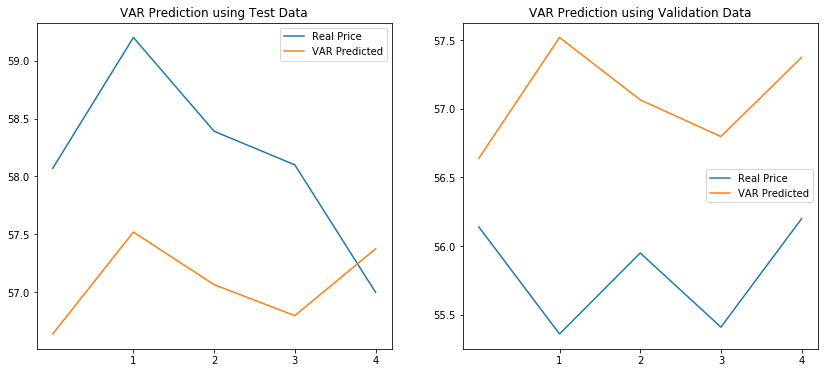

In [92]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data_test['Lloyds_Close'][:5], label='Real Price')
plt.xticks([1,2,3,4,5])
plt.plot(predictions_test_data['Lloyds_Close'][:5], label='VAR Predicted')
plt.title('VAR Prediction using Test Data')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(data_val['Lloyds_Close'][:5], label='Real Price')
plt.xticks([1,2,3,4,5])
plt.plot(predictions_val_data['Lloyds_Close'][:5], label='VAR Predicted')
plt.title('VAR Prediction using Validation Data')

plt.legend(loc='best')

plt.show()


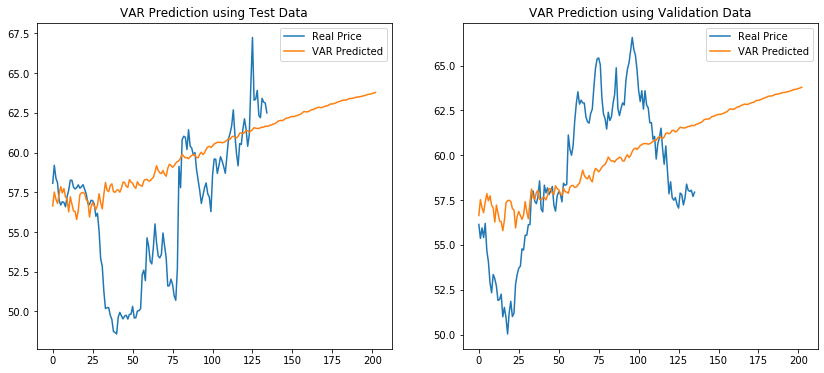

In [93]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data_test['Lloyds_Close'], label='Real Price')
plt.xticks()
plt.plot(predictions_test_data['Lloyds_Close'], label='VAR Predicted')
plt.title('VAR Prediction using Test Data')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(data_val['Lloyds_Close'], label='Real Price')
plt.xticks()
plt.plot(predictions_val_data['Lloyds_Close'], label='VAR Predicted')
plt.title('VAR Prediction using Validation Data')

plt.legend(loc='best')

plt.show()

In [96]:
mape_train=mean_absolute_percentage_error(data_train['Lloyds_Close'][271:],predictions_train_data['Lloyds_Close'])
mae_train=mean_absolute_error(data_train['Lloyds_Close'][271:],predictions_train_data['Lloyds_Close'])

mape_test_2=mean_absolute_percentage_error(data_test['Lloyds_Close'][:2],predictions_test_data['Lloyds_Close'][:2])
mae_test_2=mean_absolute_error(data_test['Lloyds_Close'][:2],predictions_test_data['Lloyds_Close'][:2])

mape_test_5=mean_absolute_percentage_error(data_test['Lloyds_Close'][:5],predictions_test_data['Lloyds_Close'][:5])
mae_test_5=mean_absolute_error(data_test['Lloyds_Close'][:5],predictions_test_data['Lloyds_Close'][:5])


print('MAPE of Training Data : ',round(mape_train,3))
print('MAE of Training Data : ',round(mae_train,3))
print('-'*30)
print('MAPE of Test Data (Short-term prediction) : ', round(mape_test_2,3))

print('-'*30)
print('MAE of Test Data (Short-term prediction) : ', round(mae_test_2,3))

print('-'*30)
print('MAE of Test Data (Long-term prediction) : ', round(mae_test_5,3))

print('-'*30)
print('MAPE of Test Data (Long-term prediction) : ', round(mape_test_5,3))


MAPE of Training Data :  26.762
MAE of Training Data :  11.758
------------------------------
MAPE of Test Data (Short-term prediction) :  2.651
------------------------------
MAE of Test Data (Short-term prediction) :  1.555
------------------------------
MAE of Test Data (Long-term prediction) :  1.222
------------------------------
MAPE of Test Data (Long-term prediction) :  2.094


# Errors plots

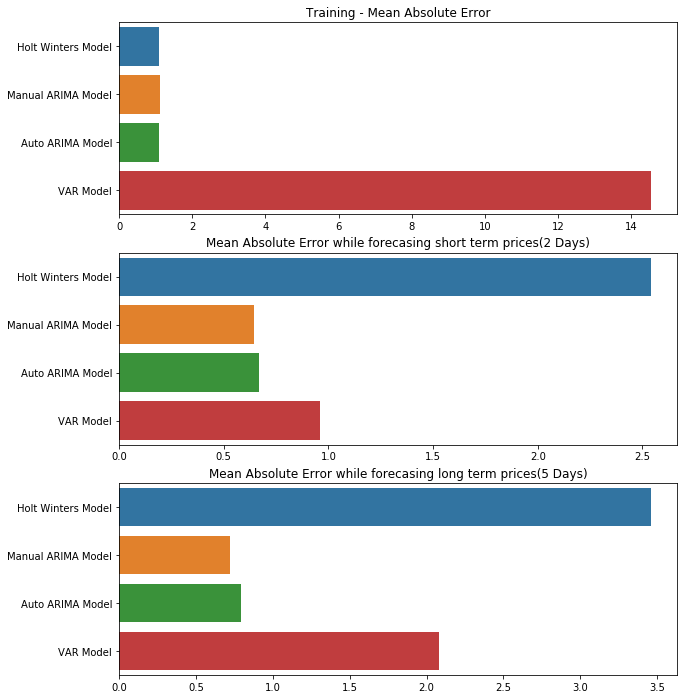

In [7]:
mae_train_error=[1.096,1.107,1.104,14.52]
mae_test_error_2=[2.539,0.643,0.668,0.958]
mae_test_error_5=[3.457,0.723,0.792,2.082]
ts_models=['Holt Winters Model','Manual ARIMA Model','Auto ARIMA Model','VAR Model']

plt.figure(figsize=(10,12))
plt.subplot(311)
sns.barplot(y=ts_models,x=mae_train_error)
plt.title('Training - Mean Absolute Error')

plt.subplot(312)
sns.barplot(y=ts_models,x=mae_test_error_2)
plt.title('Mean Absolute Error while forecasing short term prices(2 Days)')

plt.subplot(313)
sns.barplot(y=ts_models,x=mae_test_error_5)
plt.title('Mean Absolute Error while forecasing long term prices(5 Days)')

plt.show()